## Begin

### Import Statements

In [1]:
import pandas as pd
import itertools
import json
import numpy as np
import re

### Load DataFrame

#### Constants

In [2]:
algorithms = ['MDS', 'TSNE', 'RANDOM']

#### Function to Load

In [14]:
def ret_df(filepath: str):
    # Read the JSON file
    with open(filepath, 'r') as f:
        data = json.load(f)

    # Create a list to store the data
    rows = []
    for dataset_key, values in data.items():
        # Split dataset name and number
        if 'fashion_mnist' in dataset_key:
            dataset_key = dataset_key.replace('fashion_mnist', 'fashion MNIST')

        dataset, run = dataset_key.split('_')
        
        # For each metric in the values
        for metric_key, value in values.items():
            # Split algorithm and metric type
            algorithm, metric = metric_key.split('_')
            
            # Add to rows
            rows.append({
                'Dataset': dataset,
                'Run': int(run),
                'Algorithm': algorithm,
                'Metric': metric,
                'Value': value
            })

        df = pd.DataFrame(rows)
    # Pivot the DataFrame to get the desired structure
    df = df.pivot_table(
        index=['Dataset', 'Run'],
        columns=['Metric', 'Algorithm'],
        values='Value'
    )

    # Get rid of the 'UMAP' column
    df = df.drop(columns=['UMAP'], level=1)

    # Rename the metric level of the columns
    metric_mapping = {
        'raw': 'RS',
        'norm': 'NS', 
        'sheppard': 'SGS',
        'scalenorm': 'SNS',
        'kruskal': 'NMS',
    }
    df.columns = pd.MultiIndex.from_tuples(
        [(metric_mapping[m], a) for m, a in df.columns],
        names=['Metric', 'Algorithm']
    )

    df = df[['RS', 'NS', 'SGS', 'NMS', 'SNS']]
    
    # Normalize SGS to between 0 and 1, lower is better
    df.loc[:, ('SGS', algorithms)] = (1 - df.loc[:, ('SGS', algorithms)]) / 2

    return df

#### Create DataFrames for out1x and out10x

In [15]:
stress_1x_df = ret_df('out1x.json')
stress_10x_df = ret_df('out10x.json')

In [17]:
stress_1x_df

Metric                  RS                                    NS            \
Algorithm              MDS        RANDOM          TSNE       MDS    RANDOM   
Dataset  Run                                                                 
auto-mpg 0    1.123488e+11  1.124137e+11  1.069336e+11  0.999370  0.999659   
         1    1.123487e+11  1.124110e+11  1.067576e+11  0.999370  0.999647   
         2    1.123488e+11  1.124135e+11  1.073501e+11  0.999370  0.999658   
         3    1.123488e+11  1.124112e+11  1.070138e+11  0.999370  0.999648   
         4    1.123489e+11  1.124098e+11  1.071733e+11  0.999370  0.999641   
...                    ...           ...           ...       ...       ...   
wine     5    3.119957e+09  3.125498e+09  2.971871e+09  0.998167  0.999053   
         6    3.119893e+09  3.125282e+09  2.961835e+09  0.998156  0.999018   
         7    3.120044e+09  3.125801e+09  2.966535e+09  0.998180  0.999101   
         8    3.120036e+09  3.125752e+09  2.971616e+09  0.998179  0.999093   
         9    3.119837e+09  3.125472e+09  2.973683e+09  0.998147  0.999048   

Metric                       SGS                           NMS            \
Algorithm         TSNE       MDS    RANDOM      TSNE       MDS    RANDOM   
Dataset  Run                                                               
auto-mpg 0    0.974988  0.071710  0.503394  0.108256  0.264968  0.428563   
         1    0.974185  0.070919  0.481161  0.100940  0.263822  0.430236   
         2    0.976885  0.071346  0.491444  0.136565  0.265475  0.429116   
         3    0.975353  0.071033  0.489675  0.108411  0.264560  0.427759   
         4    0.976080  0.071543  0.483542  0.112604  0.265270  0.430661   
...                ...       ...       ...       ...       ...       ...   
wine     5    0.974190  0.318084  0.492347  0.278058  0.407994  0.427510   
         6    0.972544  0.311590  0.475536  0.261729  0.405513  0.427367   
         7    0.973315  0.328714  0.507620  0.264168  0.412159  0.429816   
         8    0.974148  0.326944  0.501638  0.270555  0.411829  0.429982   
         9    0.974487  0.301059  0.489028  0.271614  0.402710  0.428396   

Metric                       SNS                      
Algorithm         TSNE       MDS    RANDOM      TSNE  
Dataset  Run                                          
auto-mpg 0    0.323343  0.287544  0.691967  0.410559  
         1    0.321726  0.286449  0.679142  0.391312  
         2    0.338502  0.287835  0.684533  0.435032  
         3    0.322636  0.286936  0.682526  0.407412  
         4    0.321250  0.286859  0.679574  0.415402  
...                ...       ...       ...       ...  
wine     5    0.482777  0.589809  0.699367  0.596236  
         6    0.480599  0.585654  0.689790  0.584413  
         7    0.477695  0.598024  0.707554  0.583818  
         8    0.474829  0.596811  0.706253  0.588388  
         9    0.484178  0.578324  0.698186  0.590791  

[240 rows x 15 columns]

In [18]:
stress_df = pd.read_csv('csv_files/stress_metrics.csv', index_col=[0, 1, 2])
algorithms = ['MDS', 'TSNE', 'RANDOM']
stress_df = stress_df.loc[:, :, algorithms]

## Percent Orders

In [19]:
def get_pct_order_df(df):
    permutations = itertools.permutations(algorithms)

    results = {}

    for perm in permutations:
        condition = pd.DataFrame(True, index=df.index, columns=df.columns.get_level_values(0).unique())
        for i in range(1, len(perm)):
            condition &= df.xs(perm[i-1], axis=1, level=1) <= df.xs(perm[i], axis=1, level=1)

        percentage = (condition).mean() * 100
        # results[" < ".join(perm)] = f"{percentage:.3}%"
        results[" < ".join(perm)] = percentage

    pct_order_df = pd.DataFrame(results).T
    # Round the following styler to 2nd decimal place
    return pct_order_df.style.background_gradient('Blues', vmin=0, vmax=150).format(lambda x : f"{x:.1f}%")

In [20]:
get_pct_order_df(stress_1x_df)

Metric,RS,NS,SGS,NMS,SNS
MDS < TSNE < RANDOM,4.2%,4.2%,93.3%,81.7%,90.0%
MDS < RANDOM < TSNE,83.3%,83.3%,0.0%,18.3%,8.3%
TSNE < MDS < RANDOM,12.5%,12.5%,6.7%,0.0%,1.7%
TSNE < RANDOM < MDS,0.0%,0.0%,0.0%,0.0%,0.0%
RANDOM < MDS < TSNE,0.0%,0.0%,0.0%,0.0%,0.0%
RANDOM < TSNE < MDS,0.0%,0.0%,0.0%,0.0%,0.0%


In [21]:
get_pct_order_df(stress_10x_df)

Metric,RS,NS,SGS,NMS,SNS
MDS < TSNE < RANDOM,0.0%,0.0%,93.3%,81.7%,90.0%
MDS < RANDOM < TSNE,7.5%,7.5%,0.0%,18.3%,8.3%
TSNE < MDS < RANDOM,12.5%,12.5%,6.7%,0.0%,1.7%
TSNE < RANDOM < MDS,0.0%,0.0%,0.0%,0.0%,0.0%
RANDOM < MDS < TSNE,80.0%,80.0%,0.0%,0.0%,0.0%
RANDOM < TSNE < MDS,0.0%,0.0%,0.0%,0.0%,0.0%


## Correlation

In [22]:
score_corr_df = stress_1x_df.stack('Algorithm', future_stack=True).corr('spearman')
score_corr_df

Metric,RS,NS,SGS,NMS,SNS
Metric,,,,,
RS,1.000000,0.778313,0.090807,0.210858,0.296959
NS,0.778313,1.000000,0.159894,0.256835,0.323222
SGS,0.090807,0.159894,1.000000,0.888795,0.845801
NMS,0.210858,0.256835,0.888795,1.000000,0.879025
SNS,0.296959,0.323222,0.845801,0.879025,1.000000


In [42]:
def corr_styler(df: pd.DataFrame):
    df = df
    df = df.round(2)
    mask = np.tril(np.ones(df.shape), k=-1).astype(bool)
    upper_triangled = df.mask(mask, -2)
    return upper_triangled.style.background_gradient('Blues', vmin=0, vmax=2).format(lambda x : '-' if x == -2 else x)
    
corr_styler(score_corr_df)

Metric,RS,NS,SGS,NMS,SNS
Metric,,,,,
RS,1.0,0.78,0.09,0.21,0.3
NS,-,1.0,0.16,0.26,0.32
SGS,-,-,1.0,0.89,0.85
NMS,-,-,-,1.0,0.88
SNS,-,-,-,-,1.0


## Latex

In [40]:
def get_latex_code(styler: pd.io.formats.style.Styler, entry_type='corr'):
    """
    Parameters
    ----------
    styler : 
    entry_type : 'corr' or 'pct'
    """
    corr_df = styler.data
    entries = corr_df.to_numpy()
    index = corr_df.index.tolist()
    cols = corr_df.columns.tolist()

    corr_css = styler.to_html()
    # print(corr_css)
    n_cols = len(styler.columns)
    n_rows = len(styler.index)
    colors = [["f"*6] * n_cols for _ in range(n_rows)]

    
    matches = re.findall(r'#T_\w+_row(\d+)_col(\d+)[^}]+background-color: #(\w+);', corr_css)

    # Fill the grid with the extracted background colors
    for match in matches:
        # print(match)
        row, col, color = int(match[0]), int(match[1]), match[2]
        colors[row][col] = color
    colors = np.array(colors)

    latex_code = f"""\\begin{{table}}[ht]
\\centering
\\caption{{}}
\\begin{{tabularx}}{{\\linewidth}}{{|p{{2cm}}| {'X ' * n_cols} |}}
\hline
"""

    for col in cols:
        latex_code += f"& \\small{{{col}}} "
    latex_code += "\\\\ \\hline \n"

    if entry_type == 'pct':
        index = [idx.replace(" < ", "$<$").replace("TSNE", "t-SNE").replace("RANDOM", "RND") for idx in index]

    for i in range(n_rows):
        latex_code += index[i]
        for color, entry in zip(colors[i], entries[i]):
            if entry_type == 'corr':
                tab_entry = entry if entry != -2 else '--'
            elif entry_type == 'pct':
                tab_entry = f'{float(entry):.1f}\\%'
            else:
                raise ValueError(f"entry_type should be either 'corr' or 'pct'. Got {entry_type} instead")
            latex_code += f" & \\cellcolor[HTML]{{{color}}} {tab_entry} "
        latex_code += "\\\\ \\hline \n"
    
    latex_code += """\\end{tabularx}
\\newline
\\label{tab:}
\\end{table}"""

    print(latex_code)
    return colors


In [43]:

get_latex_code(corr_styler(score_corr_df), entry_type='corr')

\begin{table}[ht]
\centering
\caption{}
\begin{tabularx}{\linewidth}{|p{2cm}| X X X X X  |}
\hline
& \small{RS} & \small{NS} & \small{SGS} & \small{NMS} & \small{SNS} \\ \hline 
RS & \cellcolor[HTML]{6aaed6} 1.0  & \cellcolor[HTML]{99c7e0} 0.78  & \cellcolor[HTML]{eef5fc} 0.09  & \cellcolor[HTML]{e3eef8} 0.21  & \cellcolor[HTML]{d9e8f5} 0.3 \\ \hline 
NS & \cellcolor[HTML]{f7fbff} --  & \cellcolor[HTML]{ffffff} 1.0  & \cellcolor[HTML]{e7f1fa} 0.16  & \cellcolor[HTML]{ddeaf7} 0.26  & \cellcolor[HTML]{d8e7f5} 0.32 \\ \hline 
SGS & \cellcolor[HTML]{ffffff} --  & \cellcolor[HTML]{ffffff} --  & \cellcolor[HTML]{ffffff} 1.0  & \cellcolor[HTML]{82bbdb} 0.89  & \cellcolor[HTML]{8abfdd} 0.85 \\ \hline 
NMS & \cellcolor[HTML]{ffffff} --  & \cellcolor[HTML]{ffffff} --  & \cellcolor[HTML]{ffffff} --  & \cellcolor[HTML]{ffffff} 1.0  & \cellcolor[HTML]{84bcdb} 0.88 \\ \hline 
SNS & \cellcolor[HTML]{ffffff} --  & \cellcolor[HTML]{ffffff} --  & \cellcolor[HTML]{ffffff} --  & \cellcolor[HTML]{ffffff} -

array([['6aaed6', '99c7e0', 'eef5fc', 'e3eef8', 'd9e8f5'],
       ['f7fbff', 'ffffff', 'e7f1fa', 'ddeaf7', 'd8e7f5'],
       ['ffffff', 'ffffff', 'ffffff', '82bbdb', '8abfdd'],
       ['ffffff', 'ffffff', 'ffffff', 'ffffff', '84bcdb'],
       ['ffffff', 'ffffff', 'ffffff', 'ffffff', 'ffffff']], dtype='<U6')

In [38]:
get_latex_code(get_pct_order_df(stress_1x_df), entry_type='pct')

\begin{table}[ht]
\centering
\caption{}
\begin{tabularx}{\linewidth}{|p{2cm}| X X X X X  |}
\hline
& \small{RS} & \small{NS} & \small{SGS} & \small{NMS} & \small{SNS} \\ \hline 
MDS$<$t-SNE$<$RND & \cellcolor[HTML]{f2f7fd} 4.2\%  & \cellcolor[HTML]{ffffff} 4.2\%  & \cellcolor[HTML]{4292c6} 93.3\%  & \cellcolor[HTML]{5ca4d0} 81.7\%  & \cellcolor[HTML]{4a98c9} 90.0\% \\ \hline 
MDS$<$RND$<$t-SNE & \cellcolor[HTML]{58a1cf} 83.3\%  & \cellcolor[HTML]{ffffff} 83.3\%  & \cellcolor[HTML]{f7fbff} 0.0\%  & \cellcolor[HTML]{dfebf7} 18.3\%  & \cellcolor[HTML]{ecf4fb} 8.3\% \\ \hline 
t-SNE$<$MDS$<$RND & \cellcolor[HTML]{e7f0fa} 12.5\%  & \cellcolor[HTML]{ffffff} 12.5\%  & \cellcolor[HTML]{eef5fc} 6.7\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{f5fafe} 1.7\% \\ \hline 
t-SNE$<$RND$<$MDS & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{ffffff} 0.0\% \\ \hline 
RND$<$MDS$<$t-SNE & \c

array([['f2f7fd', 'ffffff', '4292c6', '5ca4d0', '4a98c9'],
       ['58a1cf', 'ffffff', 'f7fbff', 'dfebf7', 'ecf4fb'],
       ['e7f0fa', 'ffffff', 'eef5fc', 'ffffff', 'f5fafe'],
       ['ffffff', 'ffffff', 'ffffff', 'ffffff', 'ffffff'],
       ['ffffff', 'ffffff', 'ffffff', 'ffffff', 'ffffff'],
       ['ffffff', 'ffffff', 'ffffff', 'ffffff', 'ffffff']], dtype='<U6')

In [39]:
get_latex_code(get_pct_order_df(stress_10x_df), entry_type='pct')

\begin{table}[ht]
\centering
\caption{}
\begin{tabularx}{\linewidth}{|p{2cm}| X X X X X  |}
\hline
& \small{RS} & \small{NS} & \small{SGS} & \small{NMS} & \small{SNS} \\ \hline 
MDS$<$t-SNE$<$RND & \cellcolor[HTML]{f7fbff} 0.0\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{4292c6} 93.3\%  & \cellcolor[HTML]{5ca4d0} 81.7\%  & \cellcolor[HTML]{4a98c9} 90.0\% \\ \hline 
MDS$<$RND$<$t-SNE & \cellcolor[HTML]{eef5fc} 7.5\%  & \cellcolor[HTML]{ffffff} 7.5\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{dfebf7} 18.3\%  & \cellcolor[HTML]{ecf4fb} 8.3\% \\ \hline 
t-SNE$<$MDS$<$RND & \cellcolor[HTML]{e7f0fa} 12.5\%  & \cellcolor[HTML]{ffffff} 12.5\%  & \cellcolor[HTML]{ffffff} 6.7\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{f5fafe} 1.7\% \\ \hline 
t-SNE$<$RND$<$MDS & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{ffffff} 0.0\%  & \cellcolor[HTML]{ffffff} 0.0\% \\ \hline 
RND$<$MDS$<$t-SNE & \cel

array([['f7fbff', 'ffffff', '4292c6', '5ca4d0', '4a98c9'],
       ['eef5fc', 'ffffff', 'ffffff', 'dfebf7', 'ecf4fb'],
       ['e7f0fa', 'ffffff', 'ffffff', 'ffffff', 'f5fafe'],
       ['ffffff', 'ffffff', 'ffffff', 'ffffff', 'ffffff'],
       ['60a7d2', 'ffffff', 'ffffff', 'ffffff', 'ffffff'],
       ['ffffff', 'ffffff', 'ffffff', 'ffffff', 'ffffff']], dtype='<U6')

## Q3 NS vs. SNS comparison

### Load data

In [ ]:
# Download projections used in Espadoto Paper
import os
import subprocess

url = "https://mespadoto.github.io/proj-quant-eval/data/projections/projections.tar.gz"
tar_file = "projections.tar.gz"
extract_dir = "projections"

# Create directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)

    subprocess.run(["wget", url], check=True) # Download tar file
    subprocess.run(["tar", "-xzf", tar_file, "-C", extract_dir], check=True) # Extract contents
    os.remove(tar_file) # Delete tar file

In [ ]:
!wget https://mespadoto.github.io/proj-quant-eval/data/projections/projections.tar.gz && mkdir -p projections && tar -xzf projections.tar.gz -C projections && rm projections.tar.gz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from metrics import Metrics
import tqdm
import os

In [4]:
datasets = [
    "bank", "cifar10", "cnae9", "coil20", "epileptic", "fashion_mnist",
    "fmd", "har", "hatespeech", "hiva", "imdb", "secom",
    "seismic", "sentiment", "sms", "svhn"
]

# datasets = [
#     'Bank', 'CIFAR-10', 'CNAE-9', 'COIL-20', 'Epileptic', 'Fashion MNIST',
#     'FMD', 'HAR', 'Hatespeech', 'Hiva', 'IMDb', 'Secom',
#     'Seismic', 'Sentiment', 'SMS', 'SVHN'
# ]

NS_data = {
    "MDS": [1] * 16,
    "ISO": [2, 2, 2, 4, 2, 4, 2, 4, 3, 3, 3, 4, 3, 3, 2, 3],
    "LLE": [3, 4, 3, 2, 3, 3, 4, 2, 2, 4, 4, 2, 2, 2, 3, 4],
    "UMAP": [4, 3, 4, 3, 5, 2, 5, 3, 4, 2, 5, 3, 4, 4, 5, 2],
    "T-SNE": [5, 5, 5, 5, 4, 5, 3, 5, 5, 5, 2, 5, 5, 5, 4, 5]
}


SNS_data = {
    "MDS": [1] * 16,
    "ISO": [3, 2, 4, 5, 2, 2, 3, 3, 3, 4, 5, 4, 4, 4, 4, 2],
    "LLE": [5, 5, 5, 4, 4, 5, 5, 5, 4, 5, 4, 5, 5, 5, 5, 4],
    "UMAP": [4, 4, 3, 3, 5, 4, 4, 4, 5, 3, 3, 3, 3, 3, 3, 5],
    "T-SNE": [2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]
}

NS_ranking = pd.DataFrame(NS_data, index=datasets)
SNS_ranking = pd.DataFrame(SNS_data, index=datasets)

In [2]:
small_data = {"auto-mpg.npy", "iris.npy", "penguins.npy", "s-curve.npy", "swissroll.npy", "wine.npy"}
# ORL removed because error in Espadoto repo
# Epileptic removed because we downsampled it
# Spambase removed because embeddings are missing in Espadoto repo
error_data = {"spambase.npy", "epileptic.npy", "orl.npy"}

results = dict()
results_scale = dict()
datasets = [dataFname for dataFname in os.listdir('datasets') if dataFname not in small_data | error_data]


for dataFname in tqdm.tqdm(datasets):
    X = np.load(f'datasets/{dataFname}')
    dataname = dataFname.split(".")[0]
    results[dataname] = dict()
    results_scale[dataname] = dict()
    for alg in ["T-SNE", "MDS", "UMAP", "LLE", "ISO"]:

        Y = np.loadtxt(f'projections/proj_X_{dataname}_{alg}.csv', delimiter=',')

        M = Metrics(X,Y, setbatch=False)
        results[dataname][alg] = M.compute_normalized_stress()
        results_scale[dataname][alg] = M.compute_scale_normalized_stress()

100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


In [3]:
NS_ranking = pd.DataFrame.from_dict(results, orient='index')
NS_ranking = NS_ranking.rank(axis=1, method='min').astype(int)
SNS_ranking = pd.DataFrame.from_dict(results_scale, orient='index')
SNS_ranking = SNS_ranking.rank(axis=1, method='min').astype(int)

In [11]:
new_df = pd.concat(
    {
    'NS' : pd.DataFrame.from_dict(results, orient='index'),
    'SNS' : pd.DataFrame.from_dict(results_scale, orient='index')
    },
    axis=1
)
new_df.stack(level=0).rank(axis=1, method='min').unstack().reorder_levels([1, 0], axis=1)

/tmp/ipykernel_440069/2070668354.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  new_df.stack(level=0).rank(axis=1, method='min').unstack().reorder_levels([1, 0], axis=1)


,NS,SNS,NS,SNS,NS,SNS,NS,SNS,NS,SNS
,T-SNE,T-SNE,MDS,MDS,UMAP,UMAP,LLE,LLE,ISO,ISO
bank,5.0,2.0,1.0,1.0,4.0,4.0,3.0,5.0,2.0,3.0
cifar10,5.0,3.0,1.0,1.0,3.0,4.0,4.0,5.0,2.0,2.0
cnae9,5.0,2.0,1.0,1.0,4.0,3.0,3.0,5.0,2.0,4.0
coil20,5.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,4.0,5.0
fashion_mnist,5.0,3.0,1.0,1.0,2.0,4.0,3.0,5.0,4.0,2.0
fmd,3.0,2.0,1.0,1.0,5.0,4.0,4.0,5.0,2.0,3.0
har,5.0,2.0,1.0,1.0,3.0,4.0,2.0,5.0,4.0,3.0
hatespeech,5.0,2.0,1.0,1.0,4.0,5.0,2.0,4.0,3.0,3.0
hiva,5.0,2.0,1.0,1.0,2.0,3.0,4.0,5.0,3.0,4.0


In [4]:
df = pd.concat({"NS": NS_ranking, "SNS": SNS_ranking}, axis=1)
datasets = df.index.unique()
df.columns.names = ["Metric", "Algorithm"]
df

Metric           NS                    SNS                 
Algorithm     T-SNE MDS UMAP LLE ISO T-SNE MDS UMAP LLE ISO
bank              5   1    4   3   2     2   1    4   5   3
cifar10           5   1    3   4   2     3   1    4   5   2
cnae9             5   1    4   3   2     2   1    3   5   4
coil20            5   1    3   2   4     2   1    3   4   5
fashion_mnist     5   1    2   3   4     3   1    4   5   2
fmd               3   1    5   4   2     2   1    4   5   3
har               5   1    3   2   4     2   1    4   5   3
hatespeech        5   1    4   2   3     2   1    5   4   3
hiva              5   1    2   4   3     2   1    3   5   4
imdb              2   1    5   4   3     2   1    3   4   5
secom             5   1    3   2   4     2   1    3   5   4
seismic           5   1    4   2   3     2   1    3   5   4
sentiment         5   1    4   2   3     2   1    3   5   4
sms               4   1    5   3   2     2   1    3   5   4
svhn              5   1    2   4   3     3   1    5   4   2

#### Statistics

In [5]:
iso2nd = (df['NS', 'ISO'] == 2).mean()
print(f"ISO was 2nd in NS {iso2nd * 100:.2f}% of the time")
lle2nd = (df['NS', 'LLE'] == 2).mean()
print(f"LLE was 2nd in NS {lle2nd * 100:.2f}% of the time")
tsne2nd = (df['SNS', 'T-SNE'] == 2).mean()
print(f"t-SNE was 2nd in SNS {tsne2nd * 100:.2f}% of the time")

ISO was 2nd in NS 33.33% of the time
LLE was 2nd in NS 40.00% of the time
t-SNE was 2nd in SNS 80.00% of the time


In [6]:
tsne_last = (df['NS', 'T-SNE'] == 5).mean()
print(f"t-SNE was last in NS {tsne_last * 100:.2f}% of the time")
lle_last = (df['SNS', 'LLE'] == 5).mean()
print(f"LLE was last in SNS {lle_last * 100:.2f}% of the time")


t-SNE was last in NS 80.00% of the time
LLE was last in SNS 73.33% of the time


##### **SNS**

In [9]:
df['SNS'].mean(axis=0)

Algorithm
T-SNE    2.200000
MDS      1.000000
UMAP     3.600000
LLE      4.733333
ISO      3.466667
dtype: float64

In [ ]:
pd.concat({i: (df['SNS'] == i).sum() for i in range(1, 6)}, axis=1)
    

,1,2,3,4,5
Algorithm,,,,,
T-SNE,0,12,3,0,0
MDS,15,0,0,0,0
UMAP,0,0,8,5,2
LLE,0,0,0,4,11
ISO,0,3,4,6,2


##### **NS**

In [43]:
df['NS'].mean(axis=0)

Algorithm
T-SNE    4.600000
MDS      1.000000
UMAP     3.533333
LLE      2.933333
ISO      2.933333
dtype: float64

In [44]:
pd.concat({i: (df['NS'] == i).sum() for i in range(1, 6)}, axis=1)

,1,2,3,4,5
Algorithm,,,,,
T-SNE,0,1,1,1,12
MDS,15,0,0,0,0
UMAP,0,3,4,5,3
LLE,0,6,4,5,0
ISO,0,5,6,4,0


### Visualizations

In [ ]:
colors = {
    "MDS": 'darkred',
    "ISO": 'orange',
    "LLE": 'deeppink',
    "UMAP": 'purple',
    "T-SNE": 'darkblue'
}

In [54]:
import matplotlib.colors as mcolors

algs = ['MDS', 'T-SNE', 'UMAP', 'ISO', 'LLE']

# Hack to make it darker
step = 3
cmap = plt.get_cmap('Oranges', len(algs) + step)
hex_colors = [mcolors.to_hex(cmap(i + step)) for i in range(len(algs))]

colors = dict(zip(algs, hex_colors))

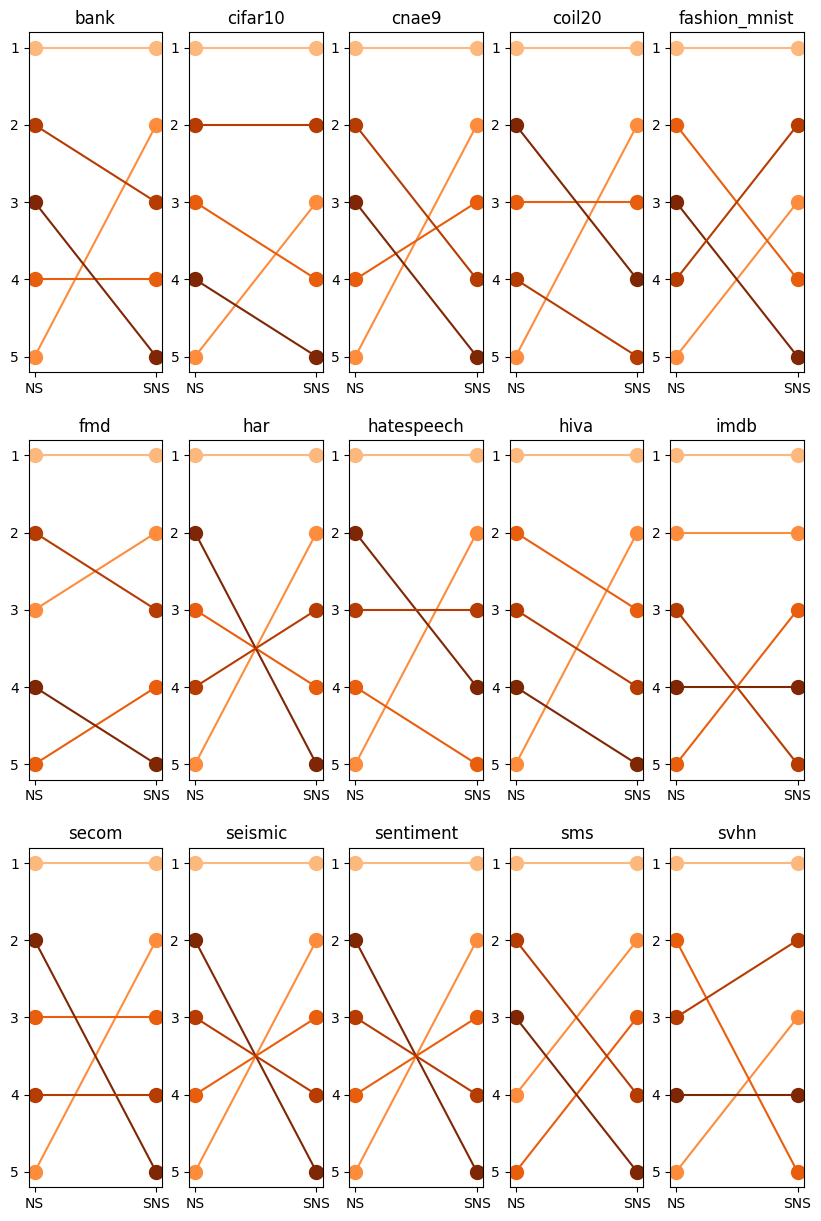

In [48]:
fig, axes = plt.subplots(3, 5, figsize=(10, 15))
for i, dataset in enumerate(datasets):
    for alg in df.columns.get_level_values(1).unique():
        plot_df = df.xs(alg, level=1, axis=1).loc[dataset]
        axes.flatten()[i].plot(- plot_df.to_numpy(), marker='o', c=colors[alg], markersize=10)
    axes.flatten()[i].set_title(dataset)
    axes.flatten()[i].set_yticks([-1, -2, -3, -4, -5])
    axes.flatten()[i].set_yticklabels([1, 2, 3, 4, 5])
    axes.flatten()[i].set_xticks([0, 1])
    axes.flatten()[i].set_xticklabels(['NS', 'SNS'])

In [55]:
n_rows = 2
n_columns = 8
size = 10
fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns * 2 * size, n_rows * 5 * size), 
                        #  sharex=True, sharey=True
)
for i, dataset in enumerate(datasets):
    ax = axes.flatten()[i]
    coords = np.column_stack((np.array([0] * 5 + [1] * 5), -df.loc[dataset].to_numpy()))

    for alg, (x,y) in zip(np.tile(df.columns.get_level_values(1).unique(), 2), coords):
        rect = plt.Rectangle((x, y), 1, 1, facecolor=colors[alg], edgecolor='black')
        ax.add_patch(rect)
        ax.text(x + 0.5, y + 0.5, alg, color='white', ha='center', va='center', fontweight='bold', fontsize=150)

    ax.set_xlim(0, 2)
    ax.set_ylim(-5, 0)
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['NS', 'SNS'], fontsize=120)
    ax.set_yticks(np.arange(-0.5, -5.5, -1))
    ax.set_yticklabels(np.arange(1, 6), fontsize=120)
    ax.set_title(dataset, fontweight='bold', fontsize=150)

    if (i % n_columns == 0): ax.set_ylabel('Position', fontsize=20 * size)
    if (i >= n_columns * (n_rows - 1)): ax.set_xlabel('Metric', fontsize=20 * size)
fig.delaxes(axes.flatten()[-1])
plt.tight_layout()

In [56]:
fig.savefig('graphics_for_paper/Q3_for_stress(2x8)_Oranges.pdf', format='pdf')

### Statistics

In [22]:
iso2nd = (df['NS', 'ISO'] == 2).mean()
print(f"ISO was 2nd in NS {iso2nd * 100:.2f}% of the time")
lle2nd = (df['NS', 'LLE'] == 2).mean()
print(f"LLE was 2nd in NS {lle2nd * 100:.2f}% of the time")
tsne2nd = (df['SNS', 'T-SNE'] == 2).mean()
print(f"t-SNE was 2nd in SNS {tsne2nd * 100:.2f}% of the time")

ISO was 2nd in NS 33.33% of the time
LLE was 2nd in NS 40.00% of the time
t-SNE was 2nd in SNS 80.00% of the time


In [24]:
tsne_last = (df['NS', 'T-SNE'] == 5).mean()
print(f"t-SNE was last in NS {tsne_last * 100:.2f}% of the time")
lle_last = (df['SNS', 'LLE'] == 5).mean()
print(f"LLE was last in SNS {lle_last * 100:.2f}% of the time")


t-SNE was last in NS 80.00% of the time
LLE was last in SNS 73.33% of the time
